In [148]:
# import all modules
import shutil
import glob
import csv
import ast
import os
import re

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
import matplotlib as mpl

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem

from mendeleev import element

from rdkit import Chem
import seaborn as sns
import pandas as pd
import numpy as np

from astroquery.linelists.cdms import CDMS
from astroquery.jplspec import JPLSpec
import astropy.units as u
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [163]:
# set rc params for matplotlib
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 12

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
mpl.rcParams['mathtext.fontset'] = 'stix'

mpl.rcParams['figure.figsize'] = [10,10]

mpl.rcParams['axes.linewidth'] = 1

# -- Ticks and tick labels --
mpl.rcParams['axes.edgecolor'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 500
mpl.rcParams['savefig.transparent'] = True

In [207]:
## CDMS ##
# https://cdms.astro.uni-koeln.de/classic/general/#format_of_quantum_numbers
# phosphine, methanol, formic acid, not used: cyclopropene,'040506 c-C3H4'
CDMS_molecule_list = ['034501 PH3','032504 CH3OH','046506 t-HCOOH']

## JPL ##
# acetonitrile, acetaldehyde, methylformate
JPL_molecule_list = ['41001 CH3CN','44003 CH3CHO','60003 CH3OCHO']

molecule_names_list = [r'Phosphine - PH$_3$', r'Methanol - CH$_3$OH', 
                       r'Formic Acid - HCOOH', r'Acetonitrile - CH$_3$CN',
                       r'Acetaldehyde - CH$_3$CHO', r'Methylformate - CH$_3$OCHO']

all_list = [('034501 PH3',r'Phosphine - PH$_3$','CDMS',0,0, 30, 'P', ['Ju', 'Ku']), ('040502 CH3CCH, v=0', r'Propyne - CH$_3$CCH', 'CDMS',0,1,10,'CC#C', ['Ju', 'Ku']),
            ('027501 HCN, v=0',r'Hydrogen cyanide - HCN','CDMS',1,0, 20, 'C#N', ['Ju']),('051501 HC3N, (0,0,0,0)',r'Prop-2-ynenitrile - HC$_3$N', 'CDMS', 1,1,7,'C#CC#N', ['Ju']),
            ('064502 SO2, v=0', r'Sulphur dioxide - SO$_2$', 'CDMS', 2, 0, 25,'O=S=O', ['Ju', 'Ku', 'vu']),('065514 HCCCH2CN', r'Propargyl cyanide - HCCCH$_2$CN','CDMS', 2,1,15,'C#CCC#N', ['Ju', 'Ku', 'vu'])]

           # Molecules with vibrational ground state transitions
           #('034501 PH3',r'Phosphine - PH$_3$','CDMS',0,0, 30, 'P')
           #('041514 CH3NC', r'Isocyanomethane - C$_2$H$_3$N', 'CDMS',0,1,15,'C[N+]#[C-]')
           #('027501 HCN, v=0',r'Hydrogen cyanide - HCN','CDMS',1,0, 25, 'C#N')
           #('051501 HC3N, (0,0,0,0)',r'Prop-2-ynenitrile - HC$_3$N', 'CDMS', 1,1,15,'C#CC#N')
           #('040502 CH3CCH, v=0', r'Propyne - CH$_3$CCH', 'CDMS',2,0,15,'CC#C')
           #('046514 CH3OCH3, v=0', r'Dimethyl ether - CH$_3$OCH$_3$', 'CDMS', 2, 1, 25, 'COC')
           #('065514 HCCCH2CN', r'Propargyl cyanide - HCCCH$_2$CN','CDMS', 2,1,15,'C#CCC#N')
           #'056507 H2NCH2CN, v=0',r'Aminoacetonitrile - NH$_2$CH$_2$CN','CDMS',1,1,15,'N#CCN'
           #
           
           
           # Unused but Good molecules
           #('041505 CH3CN, v=0', r'Acetonitrile - CH$_3$CH$_2$CN','CDMS',2,1,15,'N#CC')

           # Molecules without vibrational ground state transitions or bad formatting
           #('41001 CH3CN',r'Acetonitrile - CH$_3$CN','JPL',1,1,'N#CC'),
           #('44003 CH3CHO',r'Acetaldehyde - CH$_3$CHO','JPL',2,0,'O=CC')
           #('60003 CH3OCHO',r'Methylformate - CH$_3$OCHO','JPL',2,1,'O=COC')]
           #r'Ammonia - NH$_3$', 'CDMS', 0, 1, 50, 'N'
           #'055502 C2H5CN, v=0', r'Ethyl cyanide- C$_2$H$_5$CN','CDMS', 2,1, 100,'CCC#N'
           

In [ ]:
observed_data = CDMS.query_lines(min_frequency=0*u.MHz,
                         max_frequency=6e6*u.MHz,
                         min_strength=-10,
                         temperature_for_intensity=9.375,
                         molecule='040502 CH3CCH, v=0') 
observed_data

In [ ]:
comp_data = pd.read_csv('/Users/mpettyjo/Documents/Research/4_BigData/PGOPHER Simulations/Full/C3H4_2.csv',header=1)
comp_data

In [130]:
data_ground = pd.read_csv('/Users/mpettyjo/Documents/Research/4_BigData/B971_def2TZVPD_DataFile1_GroundState.csv')
# data_all = pd.read_csv('/Users/mpettyjo/Documents/Research/4_BigData/B971_def2TZVPD_DataFile1.csv')
# data = pd.read_csv('/Users/mpettyjo/Documents/Research/4_BigData/6_Atoms/biosig_CHNOPS.csv')

# Functions

In [132]:
def have_hyperfine(file):
    with open(file, 'r') as inp:
        for line in inp:
            line = line.strip()
            if line.startswith('Atoms with significant hyperfine tensors:'):
                if len(line.split()) == 5:
                    hyperfine = 'No'
                elif len(line.split()) > 5:
                    hyperfine = 'Yes'
    return hyperfine
    

In [133]:
def grab_constant(inp,quartic_constants):
    rot_info = next(inp).split()
    quartic_constants.append(float(rot_info[3])/29979.2458)
    return

def get_quartic_rotational_constants(file): 
    quartic_constants = []
    with open(file, 'r') as inp:
        for line in inp:
            line = line.strip()
            if line.startswith('(Asymmetrically reduced)          (Symmetrically reduced)'):
                for n in range(0,5,1):
                    grab_constant(inp,quartic_constants)
    return quartic_constants

In [136]:
## get lines from CDMS ## 
def CDMS_get_frequencues_intensities(molecule):
    ''' Grabs frequency and intensity data from CDMS for a molecule.
    
    Parameters 
    ----------
    molecule: string
              CDMS code for molecule, as given in https://cdms.astro.uni-koeln.de/cgi-bin/cdmssearch
              
    Returns
    -------
    freq: list of floats
                 List of frequencies of transitions in frequency range. Given in cm-1 units.
    
    intens:  list of floats
                 List of intensities of molecule in frequency range. Given in normalized arbitrary units.
    '''
    table = CDMS.query_lines(min_frequency=0*u.MHz,
                         max_frequency=6e6*u.MHz,
                         min_strength=-13,
                         temperature_for_intensity=9.375,
                         molecule=molecule) 
    freq = np.array(table['FREQ'])*0.0000334
    intens = 10**np.array(table['LGINT'])/np.max((10**np.array(table['LGINT'])))
    
    return freq, intens

In [137]:
## get lines from JPL ## 
def JPL_get_frequencues_intensities(molecule):
    ''' Grabs frequency and intensity data from JPL for a molecule.
    
    Parameters 
    ----------
    molecule: string
              JPL code for molecule, as given in https://spec.jpl.nasa.gov/ftp/pub/catalog/catform.html
              
    Returns
    -------
    freq: list of floats
                 List of frequencies of transitions in frequency range. Given in MHz units.
    
    intens:  list of floats
                 List of intensities of molecule in frequency range. Given in Log form and MHz nm2 units.
    '''
    table =  JPLSpec.query_lines(min_frequency=0*u.MHz,
                         max_frequency=9e7*u.MHz,
                         min_strength=-10,
                         molecule=molecule) 
    freq = np.array(table['FREQ'])*0.0000334
    intens = 10**np.array(table['LGINT'])/np.max((10**np.array(table['LGINT'])))
    return freq, intens

In [145]:
def simulated_frequencies_intensities(formula):
    df = pd.read_csv('/Users/mpettyjo/Documents/Research/4_BigData/PGOPHER Simulations/Full/'+formula+'.csv',header=1)
    freq = np.array(df['Position'])
    intens = np.array(df['Intensity'])/np.nanmax(df[['Intensity']].values)
    return freq, intens

In [139]:
def plot_CDMS_JPL(freq, intens, source, i , j):
    ''' Short sentence here.
    
    Parameters
    ----------
    
    Returns 
    -------
    
    '''
    #freq_axis, intens_axis = givewidth(freq, intens) # normalize intensities again
    #ax[i,j].plot(freq, -np.array(intens),
    #        color='grey', label = source)
    markers,stems,base = ax[i,j].stem(freq,-intens,markerfmt=' ', basefmt=' ', linefmt='grey')
    plt.setp(stems, 'linewidth', 1)
    return

In [140]:
def plot_simulation(freq, intens, i , j):
    markers,stems,base = ax[i,j].stem(freq,intens,markerfmt=' ', basefmt=' ', linefmt='steelblue')
    ax[i,j].hlines(y=0, xmin=0, xmax=100, linewidth=2, colors='k', linestyle=':')
    plt.setp(stems, 'linewidth', 1)
    return
    

In [141]:
def wavenumbers2MHz(x):
    return (x * 29979.2458)/1000

def MHztowavenumbers(x):
    return x * 0.0000334

In [142]:
def get_CDMS_Simulated_Common_Lines(loc_QNs,mol_id,formula):
    comp_data = pd.read_csv('/Users/mpettyjo/Documents/Research/4_BigData/PGOPHER Simulations/Full/'+formula+'.csv',header=1)
    observed_data = CDMS.query_lines(min_frequency=0*u.MHz,
                         max_frequency=6e6*u.MHz,
                         min_strength=-10,
                         temperature_for_intensity=9.375,
                         molecule=mol_id) 
    CDMS_freq_list = np.array(observed_data['FREQ'])*0.0000334
    comp_pos_list = np.array(comp_data[~np.isnan(np.array(comp_data['Position']))]['Position'])

    if len(loc_QNs) == 1:
        J = loc_QNs[0]
        obs_J_upper_list = list(observed_data[J])
        obs_J_lower_list = [label for label in observed_data['F']]

        comp_J_lower_list = np.array(comp_data[~np.isnan(np.array(comp_data['J"']))]['J"'])
        comp_J_upper_list = np.array(comp_data[~np.isnan(np.array(comp_data["J'"]))]["J'"])

        CDMS_J = list(zip(obs_J_upper_list, obs_J_lower_list))
        comp_J = list(zip(comp_J_upper_list, comp_J_lower_list))
        
        common_freq_CDMS = []
        common_pos_comp = []
        common_QN = []

        for tup in CDMS_J:
            if tup in comp_J:
                loc_comp = comp_J.index(tup)
                loc_CDMS = CDMS_J.index(tup)

                common_QN.append(tup)
                common_freq_CDMS.append(CDMS_freq_list[loc_CDMS])
                common_pos_comp.append(comp_pos_list[loc_comp])

    elif len(loc_QNs) == 2:
        J, K = loc_QNs[0],loc_QNs[1]
        obs_J_upper_list, obs_K_upper_list = list(observed_data[J]), list(observed_data[K]) 
        intermediate_J_lower_list = [label.split('-') if '-' in label else label.split(' ') for label in observed_data['F']]
        obs_J_lower_list = [int(JK[0]) for JK in intermediate_J_lower_list]
        obs_K_lower_list = [int(JK[1]) for JK in intermediate_J_lower_list]
    
        comp_J_lower_list = np.array(comp_data[~np.isnan(np.array(comp_data['J"']))]['J"'])
        comp_J_upper_list = np.array(comp_data[~np.isnan(np.array(comp_data["J'"]))]["J'"])

        comp_K_lower_list = [int(label.split()[7]) for label in list(comp_data['Label']) if str(label).split()[0] != 'nan']
        comp_K_upper_list = [int(label.split()[2]) for label in list(comp_data['Label']) if str(label).split()[0] != 'nan']

        
        
        CDMS_J_K = list(zip(obs_J_upper_list, obs_K_upper_list, obs_J_lower_list, obs_K_lower_list))
        comp_J_K = list(zip(comp_J_upper_list, comp_K_upper_list, comp_J_lower_list, comp_K_lower_list))

        common_freq_CDMS = []
        common_pos_comp = []
        common_QN = []

        for tup in CDMS_J_K:
            if tup in comp_J_K:
                loc_comp = comp_J_K.index(tup)
                loc_CDMS = CDMS_J_K.index(tup)

                common_QN.append(tup)
                common_freq_CDMS.append(CDMS_freq_list[loc_CDMS])
                common_pos_comp.append(comp_pos_list[loc_comp])
        
    elif len(loc_QNs) == 3:
        J, Ka, Kc = loc_QNs[0],loc_QNs[1], loc_QNs[2]
        obs_J_upper_list, obs_Ka_upper_list, obs_Kc_upper_list = list(observed_data[J]), list(observed_data[Ka]) , list(observed_data[Kc])
        intermediate_J_lower_list = [re.findall('..',label) if len(label) == 6 else label.split() for label in observed_data['F']]#[label.split('-') if '-' in label else label.split(' ') for label in observed_data['F']]
        obs_J_lower_list = [int(JK[0]) for JK in intermediate_J_lower_list]
        obs_Ka_lower_list = [int(JK[1]) for JK in intermediate_J_lower_list]
        obs_Kc_lower_list = [int(JK[2]) for JK in intermediate_J_lower_list]

        comp_J_upper_list = np.array([int(str(label).split()[1]) for label in list(comp_data['Label']) if str(label).split()[0] != 'nan'])
        comp_J_lower_list = np.array([int(str(label).split()[6]) for label in list(comp_data['Label']) if str(label).split()[0] != 'nan'])

        comp_Ka_upper_list = [int(label.split()[2]) for label in list(comp_data['Label']) if str(label).split()[0] != 'nan']
        comp_Ka_lower_list = [int(label.split()[7]) for label in list(comp_data['Label']) if str(label).split()[0] != 'nan']
        
        comp_Kc_upper_list = [int(label.split()[3]) for label in list(comp_data['Label']) if str(label).split()[0] != 'nan']
        comp_Kc_lower_list = [int(label.split()[8]) for label in list(comp_data['Label']) if str(label).split()[0] != 'nan']
        
        CDMS_J_Ka_Kc = list(zip(obs_J_upper_list, obs_Ka_upper_list, obs_Kc_upper_list, obs_J_lower_list, obs_Ka_lower_list, obs_Kc_lower_list))
        comp_J_Ka_Kc = list(zip(comp_J_upper_list, comp_Ka_upper_list, comp_Kc_upper_list, comp_J_lower_list, comp_Ka_lower_list, comp_Kc_lower_list))

        common_freq_CDMS = []
        common_pos_comp = []
        common_QN = []

        for tup in CDMS_J_Ka_Kc:
            if tup in comp_J_Ka_Kc:
                loc_comp = comp_J_Ka_Kc.index(tup)
                loc_CDMS = CDMS_J_Ka_Kc.index(tup)

                common_QN.append(tup)
                common_freq_CDMS.append(CDMS_freq_list[loc_CDMS])
                common_pos_comp.append(comp_pos_list[loc_comp])
        
    return (common_QN, common_pos_comp, common_freq_CDMS)

In [171]:
def compute_RMSE_positions(loc_QNs,mol_id,formula):
    common_QNs, common_pos_comp, common_freq_CDMS = get_CDMS_Simulated_Common_Lines(loc_QNs,mol_id,formula)
    J_list = list(zip(*common_QNs))[0]

    n_4=0
    n_6=0
    n_10=0
    n_20=0
    n_30=0
    sum_diff_sq_4 = 0
    sum_diff_sq_6 = 0
    sum_diff_sq_10 = 0
    sum_diff_sq_20 = 0
    sum_diff_sq_30 = 0

    i = 0
    for J in J_list:
        try:
            if J < 4:
                
                sum_diff_sq_4 += (common_pos_comp[i]-common_freq_CDMS[i])**2
                n_4+=1
            elif J < 6:
                sum_diff_sq_6 += (common_pos_comp[i]-common_freq_CDMS[i])**2
                n_6+=1
            elif J < 10: 
                sum_diff_sq_10 += (common_pos_comp[i]-common_freq_CDMS[i])**2
                n_10+=1
            elif J < 20: 
                sum_diff_sq_20 += (common_pos_comp[i]-common_freq_CDMS[i])**2
                n_20+=1
            elif J < 30: 
                sum_diff_sq_30 += (common_pos_comp[i]-common_freq_CDMS[i])**2
                n_30+=1
        except:
            print(J, common_pos_comp[i], common_freq_CDMS[i])
        i+=1

    sum_diff_all = np.sqrt(np.sum((np.array(common_pos_comp)-np.array(common_freq_CDMS))**2)/len(common_pos_comp))
    median_error = np.median(np.abs(np.array(common_pos_comp)-np.array(common_freq_CDMS)))
    
    # print(np.sqrt(sum_diff_sq_4/n_4))
    # print(np.sqrt(sum_diff_sq_6/n_6))
    # print(np.sqrt(sum_diff_sq_10/n_10))
    # print(np.sqrt(sum_diff_sq_20/n_20))
    # print(np.sqrt(sum_diff_sq_30/n_30))
    # print(sum_diff_all)
        
    return (sum_diff_all, median_error)

In [199]:
def plot_axes():
    ax[i,j].text(0.99,0.25,mol_label,horizontalalignment='right',
    verticalalignment='center',transform = ax[i,j].transAxes)
    ax[i,j].text(0.99,0.15,r'RMSE $=$ {0:.2f} cm$^{{-1}}$'.format(sum_diff_all),horizontalalignment='right',
    verticalalignment='center',transform = ax[i,j].transAxes)
    ax[i,j].text(0.99,0.05,r'Med. Error $=$ {0:.2f} cm$^{{-1}}$'.format(median_error),horizontalalignment='right',
    verticalalignment='center',transform = ax[i,j].transAxes)
    return

# Get Constants of 6 Molecules

In [940]:
df = pd.DataFrame(columns = ['Formula','SMILES','# Atoms','Conf#', 'mu_a [D]', 'mu_b [D]', 
                             'mu_c [D]', 'A [cm-1]', 'B [cm-1]', 'C [cm-1]', 'Delta_N [cm-1]',
                              'Delta_K [cm-1]', 'Delta_NK [cm-1]', 'delta_N [cm-1]', 'delta_K [cm-1]',
                               'hyperfine'])


In [941]:
# make 6 molecule dataframe 
for mol in all_list:
    SMILES = mol[-1]
    formula = data_ground[data_ground['SMILES'] == SMILES]['Formula'].values[0]
    num_atoms = data_ground[data_ground['SMILES'] == SMILES]['# Atoms'].values[0]
    conf = data_ground[data_ground['SMILES'] == SMILES]['Conf#'].values[0]
    mu_a, mu_b, mu_c = data_ground[data_ground['SMILES'] == SMILES]['mu_a [D]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['mu_b [D]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['mu_c [D]'].values[0]
    A ,B, C = data_ground[data_ground['SMILES'] == SMILES]['A [cm-1]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['B [cm-1]'].values[0], data_ground[data_ground['SMILES'] == SMILES]['C [cm-1]'].values[0]
    print(SMILES,formula,num_atoms)
    if num_atoms < 6:
        folder_num = 6
    elif (num_atoms > 6) & (num_atoms <= 8):
        folder_num = 8
    else:
        folder_num = num_atoms

    file = '/Users/z5380625/Documents/Research/4_BigData/'+str(folder_num)+'_Atoms/4_VibrationalCalcs/OutputFiles/'+formula+'_'+conf+'_harmonic_conformers.log'
    
    hyperfine = have_hyperfine(file)
    Delta_N, Delta_K, Delta_NK, delta_N, delta_K = get_quartic_rotational_constants(file)

    row_info = list([SMILES,formula,num_atoms,conf,mu_a,mu_b,mu_c,A ,B, C, Delta_N, Delta_K, Delta_NK, delta_N, delta_K, hyperfine])
    df.loc[len(df)] = row_info 

P H3P 4
CC#C C3H4_2 7
C#N CHN 3
C#CC#N C3HN 5
O=S=O O2S 3
C#CCC#N C4H3N_5 8


In [942]:
df.to_csv('/Users/z5380625/Documents/Research/4_BigData/simulation_data_six.csv',index=False,sep=',')

# Plot

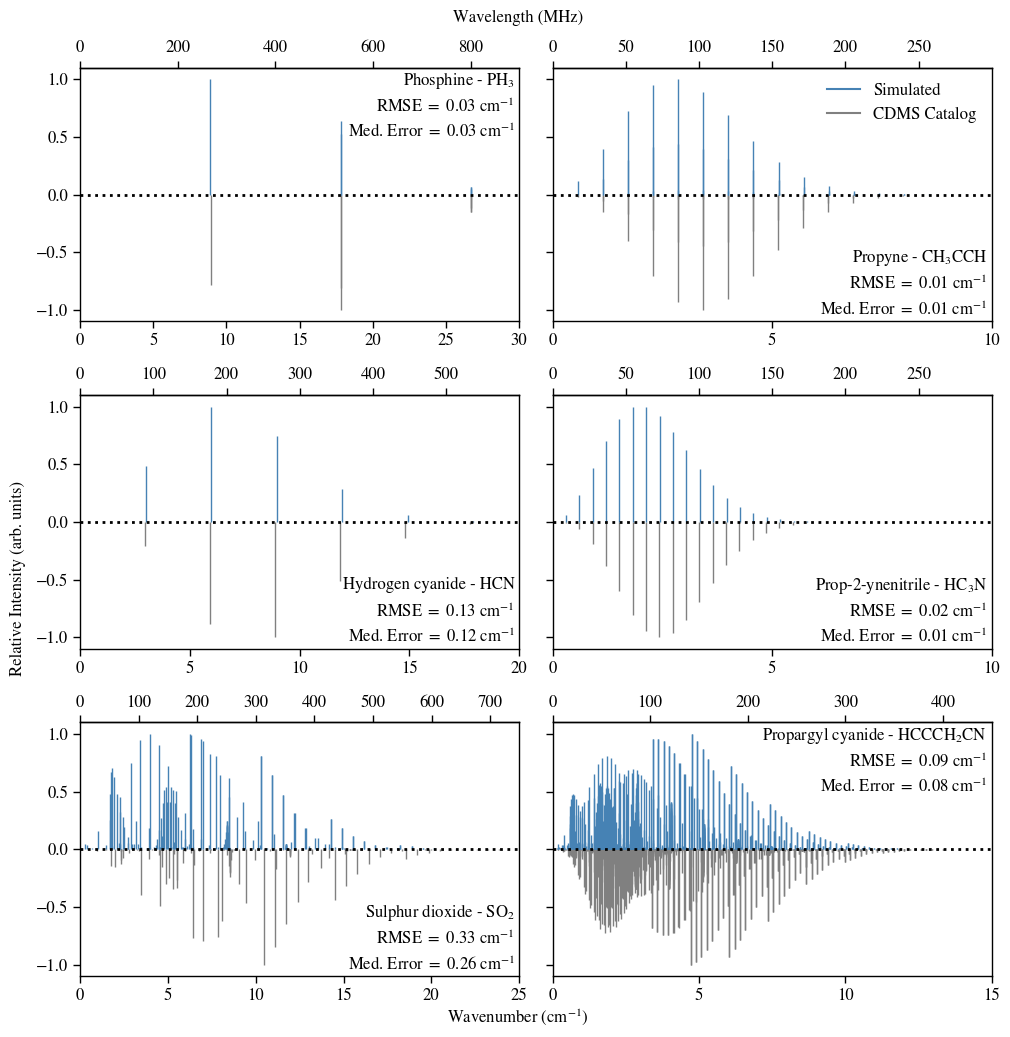

In [209]:
i_index = [0,0,1,1,2,2]
j_index = [0,1,0,1,0,1]

fig, ax = plt.subplots(3,2) 
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.1)
fig.text(0.00,0.35,"Relative Intensity (arb. units)", rotation = 'vertical', horizontalalignment = 'center')
fig.text(0.5,0.0,"Wavenumber (cm$^{-1}$)", rotation = 'horizontal', horizontalalignment = 'center')
fig.text(0.5,1.0,"Wavelength (MHz)", rotation = 'horizontal', horizontalalignment = 'center')
source_line = Line2D([0], [0], label='CDMS Catalog', color='grey')
scaled_harm = Line2D([0], [0], label='Simulated', color='steelblue')
handles_mc = [scaled_harm,source_line]
ax[0,1].legend(handles= handles_mc, ncol = 1, frameon=False, loc = 'upper right')


for mol in all_list:
    mol_id = mol[0]
    mol_formula = data_ground[data_ground['SMILES']==mol[6]]['Formula'].values[0]
    mol_label = mol[1]
    source = mol[2]
    i, j = mol[3], mol[4]
    upper = mol[5]

    loc_QNs = mol[-1]
    sum_diff_all, median_error = compute_RMSE_positions(loc_QNs,mol_id,mol_formula)
    
    if source == 'CDMS':
        freq_observ, intens_observ = CDMS_get_frequencues_intensities(mol_id)
        freq_sim, intens_sim = simulated_frequencies_intensities(mol_formula)
    elif source == 'JPL':
        freq, intens = JPL_get_frequencues_intensities(mol_id)
    
    plot_CDMS_JPL(freq_observ, intens_observ, source, i , j)
    plot_simulation(freq_sim,intens_sim,i, j)


    ax[i, j].set_xlim(0, upper)
    ax[i, j].set_xticks(np.arange(0,upper+5,5))
    ax[i, j].set_xticklabels(np.arange(0,upper+5,5))

    ax[i,j].secondary_xaxis('top',functions=(wavenumbers2MHz, MHztowavenumbers))

    if (mol_formula == 'H3P') or (mol_formula == 'C4H3N_5'): 
        ax[i,j].text(0.99,0.95,mol_label,horizontalalignment='right',
        verticalalignment='center',transform = ax[i,j].transAxes)
        ax[i,j].text(0.99,0.85,r'RMSE $=$ {0:.2f} cm$^{{-1}}$'.format(sum_diff_all),horizontalalignment='right',
        verticalalignment='center',transform = ax[i,j].transAxes)
        ax[i,j].text(0.99,0.75,r'Med. Error $=$ {0:.2f} cm$^{{-1}}$'.format(median_error),horizontalalignment='right',
        verticalalignment='center',transform = ax[i,j].transAxes)
    else:
       plot_axes()


ax[0,1].set_yticklabels([]) 
ax[1,1].set_yticklabels([]) 
ax[2,1].set_yticklabels([]) 

plt.tight_layout()
 
plt.show()

fig.savefig('rot_comparison.pdf')